In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import h5py
import config as cfg

seed = cfg.config_data['seed']

torch.manual_seed(seed)
np.random.seed(seed)

In [2]:
with h5py.File("train_test_data.h5", "r") as f:
    X_train = f["X_train"][:]
    y_train = f["y_train"][:]
    X_test = f["X_test"][:]
    y_test = f["y_test"][:]
    

scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_train)
y_scaled = scaler_Y.fit_transform(y_train)

In [3]:
class LTPDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


dataset = LTPDataset(X_scaled, y_scaled)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

X_scaled_test = scaler_X.transform(X_test)
y_scaled_test = scaler_Y.transform(y_test)

test_dataset = LTPDataset(X_scaled_test, y_scaled_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(X_scaled.shape, y_scaled.shape)
print(X_scaled_test.shape, y_scaled_test.shape)

(2850, 3) (2850, 17)
(150, 3) (150, 17)


In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [5]:

#### Define the Conditional Denoising Autoencoder (CDAE) model

### hidden_dim = 200

class ConditionalDenoisingAutoencoder(nn.Module):
    def __init__(self, ouput_dim=17, cond_dim=3, latent_dim=8, noise_std=0.5, hidden_dim=100):
        super(ConditionalDenoisingAutoencoder, self).__init__()
        self.noise_std = noise_std
        
        ###* Conditional Encoder
        self.encoder = nn.Sequential(
            nn.Linear(ouput_dim + cond_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        
        
        ###* Conditional Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, ouput_dim)
        )
    
    
    def forward(self, y, cond, add_noise=True):
        if self.training and add_noise:
            noise = torch.randn_like(y) * self.noise_std
            y_noisy = y + noise
        else:
            y_noisy = y
        
        enc_input = torch.cat([y_noisy, cond], dim=1)
        latent = self.encoder(enc_input)
        
        dec_input = torch.cat([latent, cond], dim=1)
        y_recon = self.decoder(dec_input)
        
        return y_recon, latent

In [6]:
latent_dim = 4 
cdae = ConditionalDenoisingAutoencoder(ouput_dim=17, cond_dim=3, latent_dim=latent_dim, noise_std=0.05)


num_epochs = cfg.config_cdae['num_epochs']
lr = cfg.config_cdae['lr']
criterion = nn.MSELoss()
optimizer_cdae = optim.Adam(cdae.parameters(), lr=lr)

lambda_sparse = cfg.config_cdae['lambda_sparse']
p_clean = cfg.config_cdae['p_clean']



In [7]:
cdae.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for cond, y in dataloader:
        optimizer_cdae.zero_grad()
        
        if np.random.rand() < p_clean:
            add_noise = False
        else:
            add_noise = True
        
        
        y_recon, latent = cdae(y, cond, add_noise=add_noise)
        
        
        loss_sparse = torch.mean(torch.abs(latent))
        
        loss = criterion(y_recon, y) + lambda_sparse * loss_sparse
        loss.backward()
        optimizer_cdae.step()
        epoch_loss += loss.item() * cond.size(0)
    epoch_loss /= len(dataloader.dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs} Alternating Autoencoder Loss: {epoch_loss:.5f} Sparse Loss: {loss_sparse.item():.5f}")

Epoch 1/400 Alternating Autoencoder Loss: 0.38937 Sparse Loss: 0.77587
Epoch 2/400 Alternating Autoencoder Loss: 0.07533 Sparse Loss: 0.67458
Epoch 3/400 Alternating Autoencoder Loss: 0.03163 Sparse Loss: 0.91135
Epoch 4/400 Alternating Autoencoder Loss: 0.01792 Sparse Loss: 1.64596
Epoch 5/400 Alternating Autoencoder Loss: 0.01281 Sparse Loss: 0.78570
Epoch 6/400 Alternating Autoencoder Loss: 0.01037 Sparse Loss: 0.29750
Epoch 7/400 Alternating Autoencoder Loss: 0.00826 Sparse Loss: 0.57267
Epoch 8/400 Alternating Autoencoder Loss: 0.00722 Sparse Loss: 0.44235
Epoch 9/400 Alternating Autoencoder Loss: 0.00639 Sparse Loss: 0.42744
Epoch 10/400 Alternating Autoencoder Loss: 0.00573 Sparse Loss: 0.32702
Epoch 11/400 Alternating Autoencoder Loss: 0.00538 Sparse Loss: 0.43747
Epoch 12/400 Alternating Autoencoder Loss: 0.00497 Sparse Loss: 0.17954
Epoch 13/400 Alternating Autoencoder Loss: 0.00463 Sparse Loss: 0.46891
Epoch 14/400 Alternating Autoencoder Loss: 0.00441 Sparse Loss: 0.30284
E

In [8]:

def evaluate_model_cdae(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0.0
    y_recon_vec = []
    latent_space_vec = []
    with torch.no_grad():
        for cond, y in dataloader:
            y_recon, latent_space = model(y, cond, add_noise=False)
            loss = criterion(y_recon, y)
            epoch_loss += loss.item() * cond.size(0)
        
            y_recon_vec.append(y_recon.detach().numpy())
            latent_space_vec.append(latent_space.detach().numpy())
            
    epoch_loss /= len(dataloader.dataset)
    y_recon_vec = np.concatenate(y_recon_vec, axis=0)
    latent_space_vec = np.concatenate(latent_space_vec, axis=0)
    
    return epoch_loss, y_recon_vec, latent_space_vec


loss_cdae, y_recon, latent_space = evaluate_model_cdae(cdae, test_dataloader, criterion)
print(f"Test Loss: {loss_cdae:.5f}")
print(f"RMSQ Test Loss: {np.sqrt(loss_cdae):.5f}")

Test Loss: 0.00026
RMSQ Test Loss: 0.01606


In [9]:
print(latent_space.shape)

(150, 4)


In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# z: latent vectors from the encoder
# y: class labels or condition values


y_test_vec = np.mean((y_scaled_test), axis=1)
print(y_test_vec.shape)

z = latent_space.reshape((len(latent_space), -1))  # flatten if needed

tsne = TSNE(n_components=2, perplexity=30)
z_2d = tsne.fit_transform(z)



(150,)


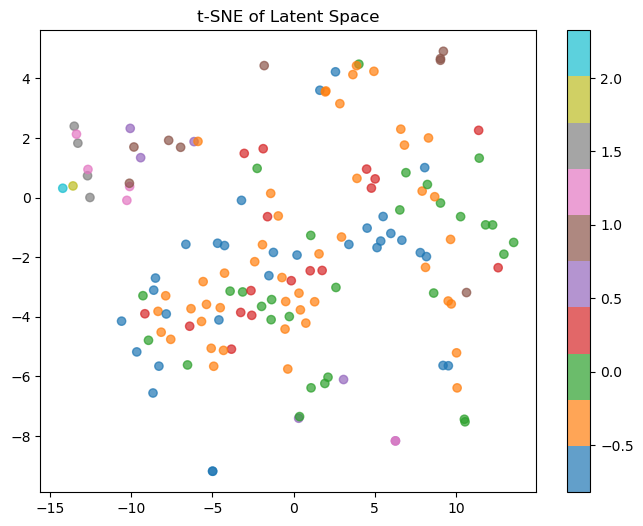

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_test_vec, cmap='tab10', alpha=0.7)
plt.colorbar()
plt.title("t-SNE of Latent Space")
plt.show()

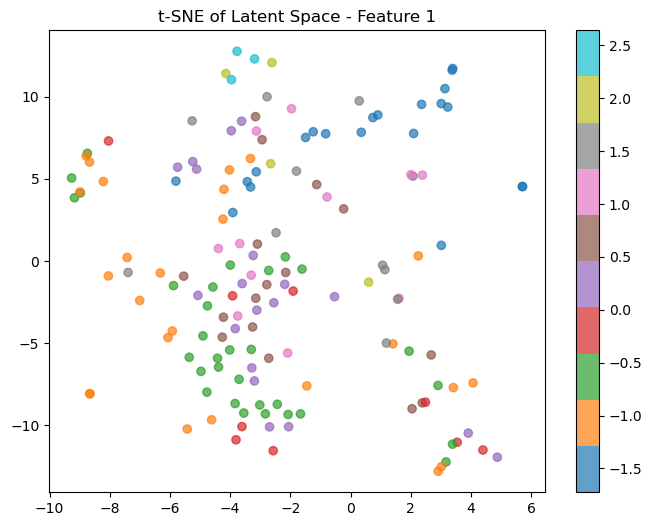

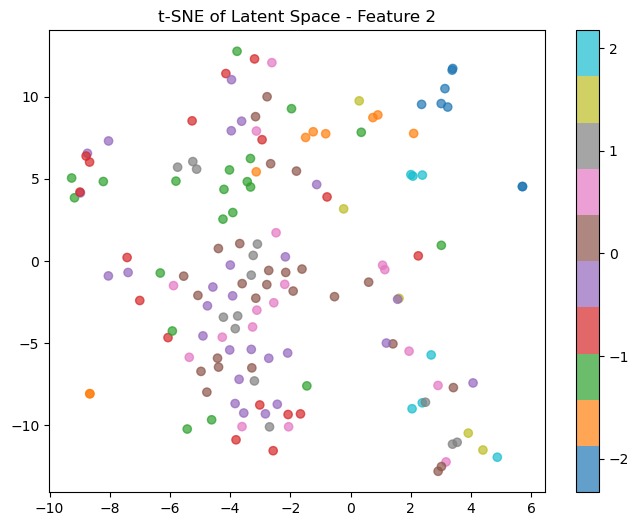

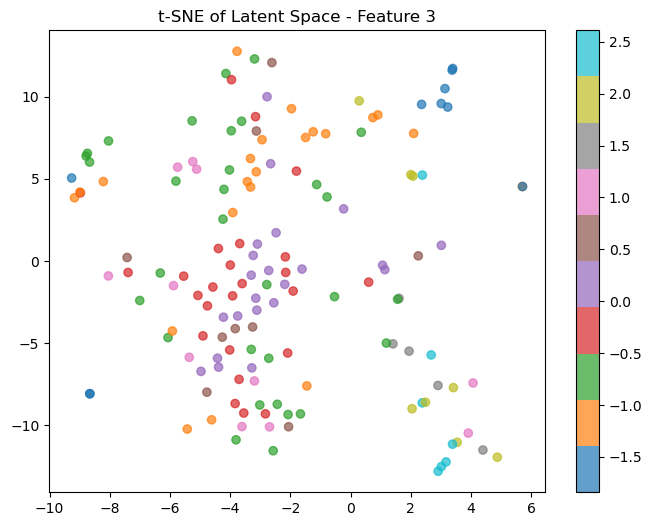

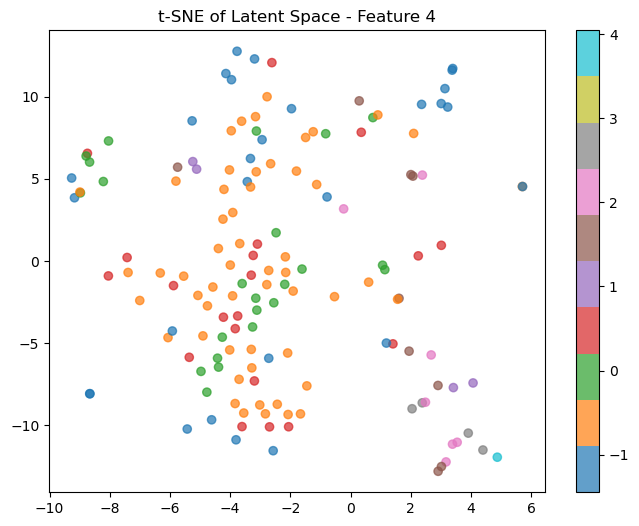

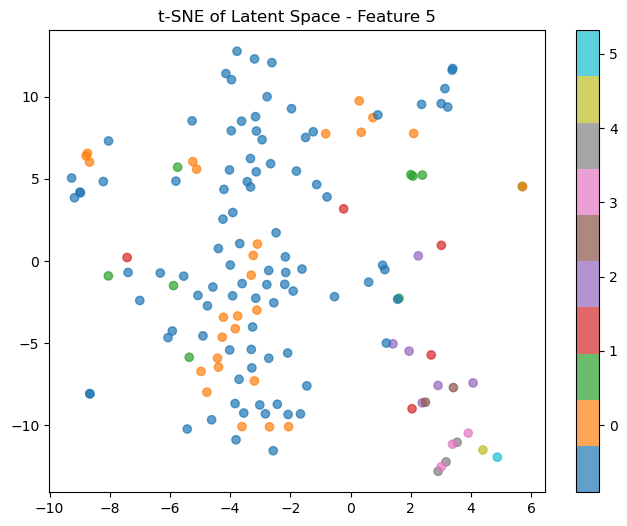

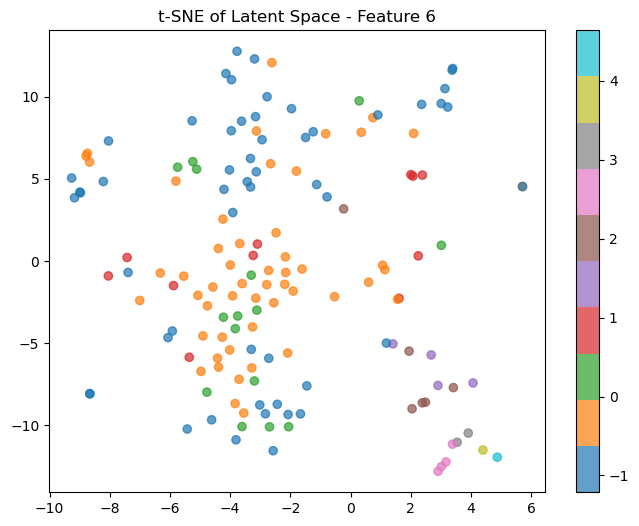

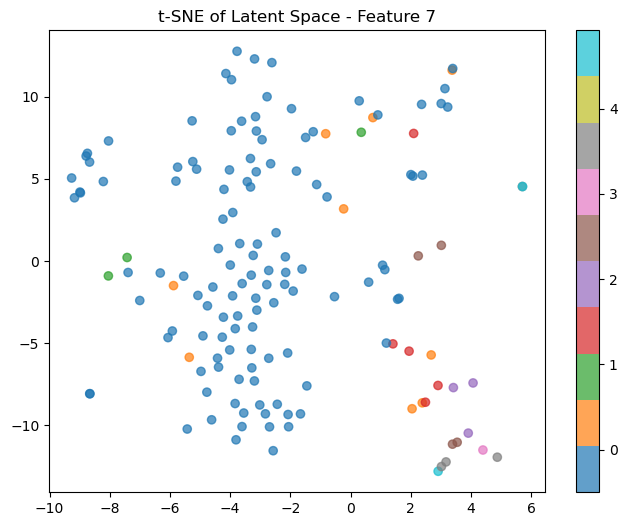

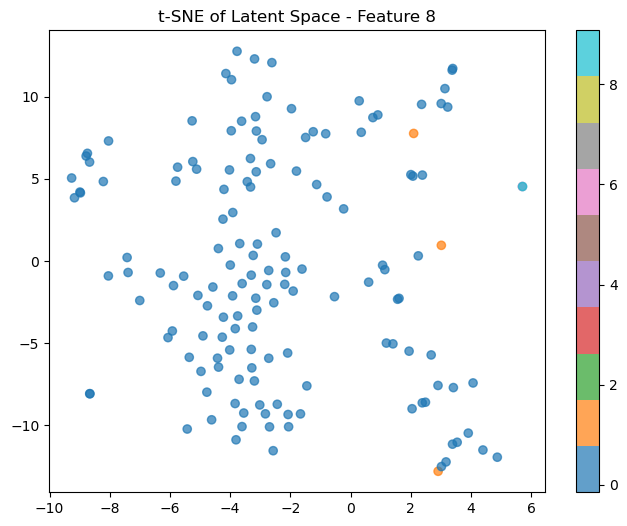

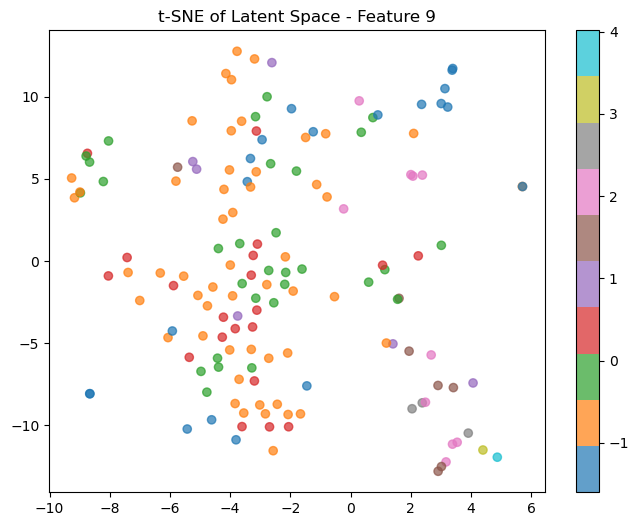

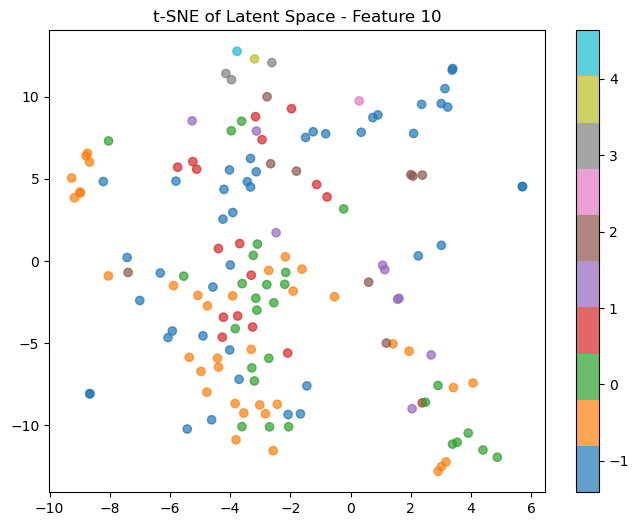

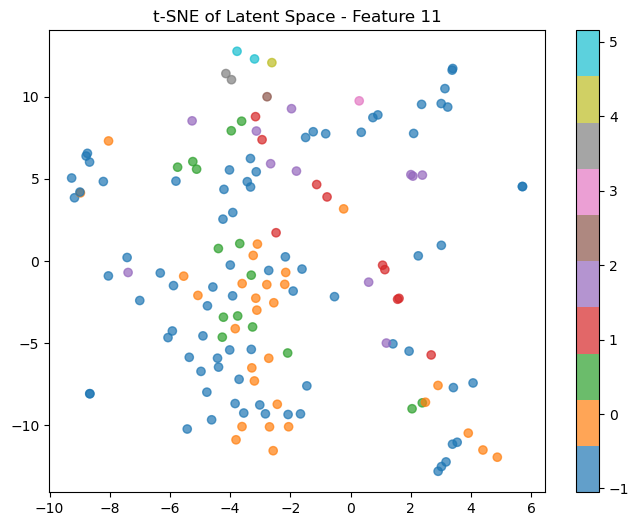

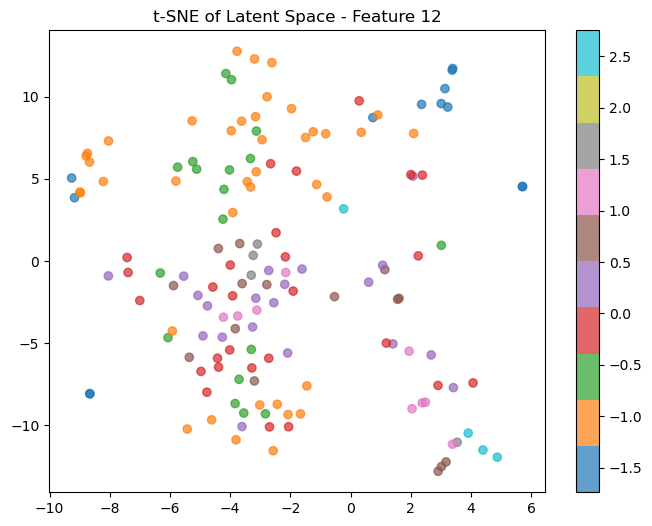

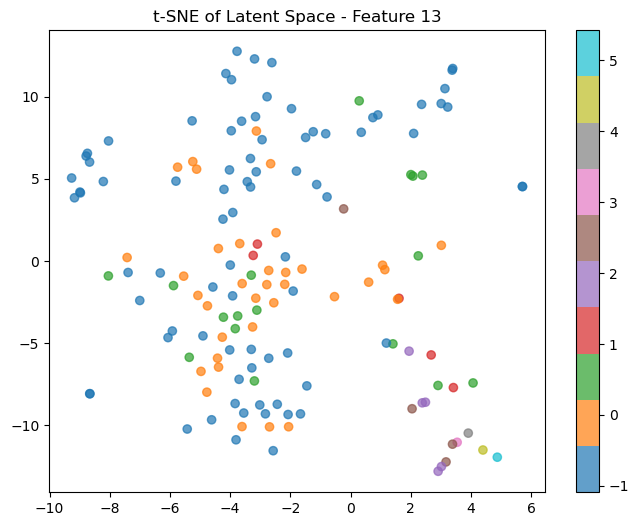

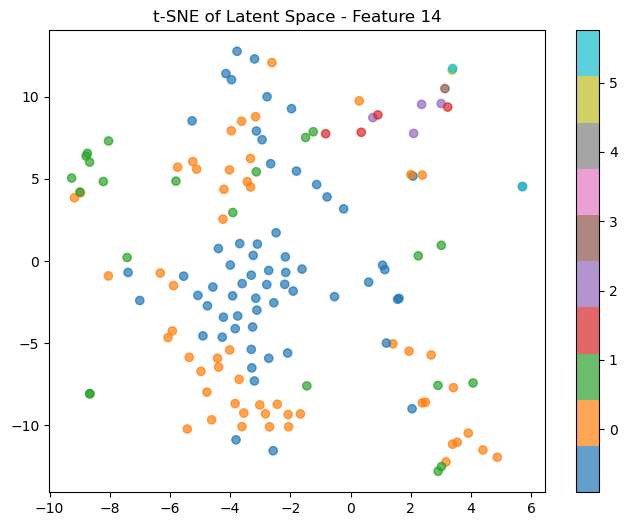

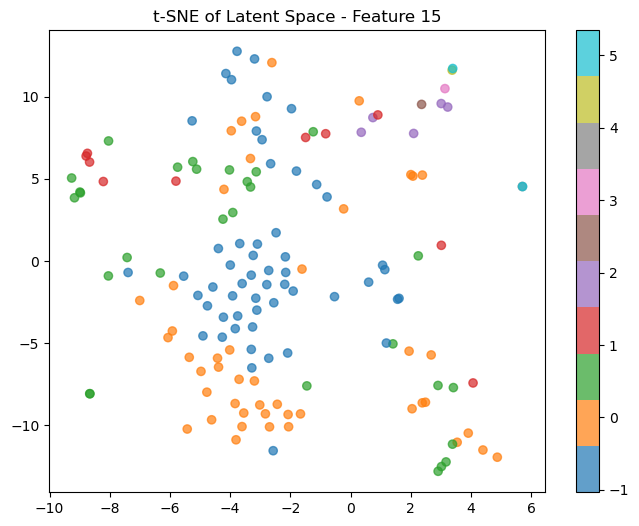

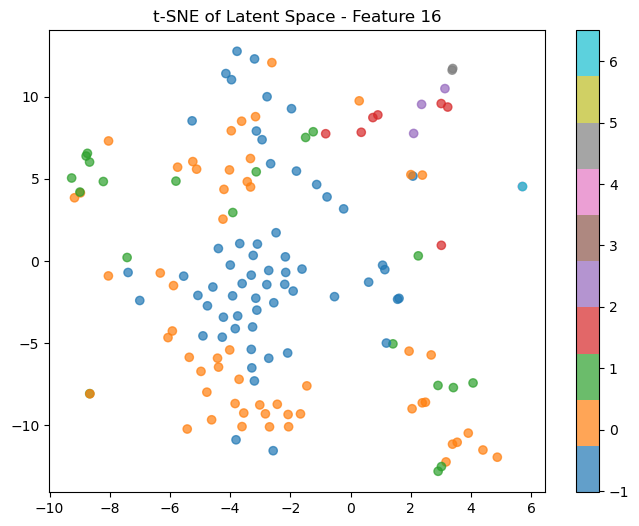

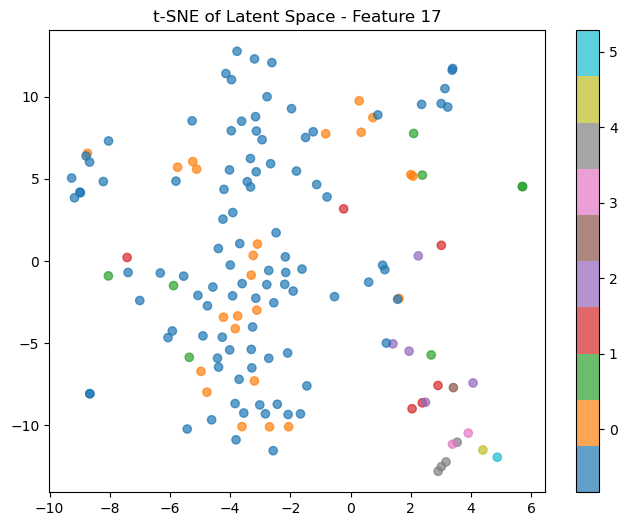

In [13]:
for i in range(y_scaled_test.shape[1]):
    plt.figure(figsize=(8,6))
    plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_scaled_test[:, i], cmap='tab10', alpha=0.7)
    plt.colorbar()
    plt.title(f"t-SNE of Latent Space - Feature {i+1}")
    plt.show()
